In [183]:
# Load libraries, add helpful functions

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv
import os, sys
from dateutil.relativedelta import relativedelta

def get_fields(field_file):
    with open(field_file, 'r') as f:
        return list(csv.reader(f))[0]  # assume only one line


def fix_birthdays(x):
    try:
        return datetime.datetime.strptime(x, '%Y%m%d')
    except (ValueError, TypeError):
        return pd.NaT

In [184]:
# Read in files and initial data frames, offense codes, and county codes

df = pd.read_csv('./data/example_arrests.csv', dtype={'CRRKCY': str})
fields = pd.read_csv('./data/fields.csv', index_col='field')
marijuana_offense_codes = pd.read_csv(
    './data/offense_codes_marijuana.csv')['code'].tolist()
cocaine_offense_codes = pd.read_csv(
    './data/offense_codes_cocaine.csv')['code'].tolist()
heroin_offense_codes = pd.read_csv(
    './data/offense_codes_heroin.csv')['code'].tolist()
county_codes = pd.read_csv(
    './data/county_codes.csv', dtype={'code': str}).set_index('code')['county'].to_dict()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19,22,52,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [185]:
df = df[fields.index.tolist()]  # limit data frame to desired fields
df.rename(columns=fields['description'].to_dict(), inplace=True)
df = df.replace({'.': np.nan})
df['County'] = df['County_Number'].map(county_codes) # Make new column with column names based on column numbers
df['Defendant_Race'] = df['Defendant_Race_Code'].map({'A':'Asian', 'B': 'Black', 'H': 'Hispanic', 'I':'Indian', 'O': 'Other', 'U': 'Unknown', 'W': 'White', 'X': 'Non-person'}) # Create new column to map races
df['Probation_Length'].replace({'.':0})
df['Filing_Date'] = pd.to_datetime(df['Filing_Date'])
df['Year'] = df['File_Number_Century'] * 100 + df['File_Number_Year'] # Convert century and year to single column
df.drop(['File_Number_Century','File_Number_Year'], inplace=True, axis=1) # Drop old columns
df['Defendant_Date_of_Birth'] = pd.to_datetime(df['Defendant_Date_of_Birth'], errors='coerce')
df['Age'] = (pd.to_datetime(df['Year'], format='%Y').dt.year - df['Defendant_Date_of_Birth'].dt.year)

# Limit to different types of drug offenses
marijuana = df[df['Charged_Offense_Code'].isin(marijuana_offense_codes)]
cocaine = df[df['Charged_Offense_Code'].isin(cocaine_offense_codes)]
heroin = df[df['Charged_Offense_Code'].isin(heroin_offense_codes)]

In [186]:
df['Age']

0       19.0
1       19.0
2       19.0
3       19.0
4       19.0
5       19.0
6       23.0
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12      25.0
13       NaN
14      26.0
15      26.0
16      28.0
17      33.0
18      33.0
19      33.0
20      21.0
21      34.0
22      34.0
23       NaN
24       NaN
25      29.0
26      29.0
27      29.0
28       NaN
29       NaN
        ... 
9970    21.0
9971    39.0
9972    27.0
9973    27.0
9974    21.0
9975    21.0
9976    39.0
9977    39.0
9978    58.0
9979    20.0
9980    20.0
9981    20.0
9982    50.0
9983    50.0
9984    32.0
9985    32.0
9986    32.0
9987    25.0
9988    25.0
9989    25.0
9990    25.0
9991    26.0
9992    26.0
9993    26.0
9994    43.0
9995    43.0
9996    43.0
9997    47.0
9998    47.0
9999    31.0
Name: Age, Length: 10000, dtype: float64

Text(0, 0.5, 'Count')

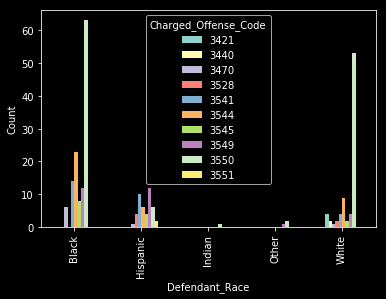

In [187]:
marijuana.groupby(['Defendant_Race', 'Charged_Offense_Code']).count()['County'].unstack('Charged_Offense_Code').plot.bar()
plt.ylabel('Count')

Text(0, 0.5, 'Count')

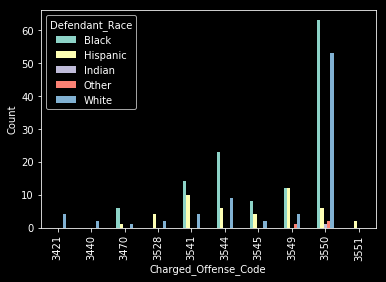

In [188]:
marijuana.groupby(['Defendant_Race', 'Charged_Offense_Code']).count()['County'].unstack('Defendant_Race').plot.bar()
plt.ylabel('Count')

In [189]:
marijuana_race_offense_code = marijuana.groupby(['Defendant_Race', 'Charged_Offense_Code']).count()['County'].unstack('Defendant_Race')
marijuana_race_offense_code
marijuana_offense_code_counts = marijuana_race_offense_code.T.sum()
marijuana_race_counts = marijuana_race_offense_code.sum()

Text(0, 0.5, 'Count')

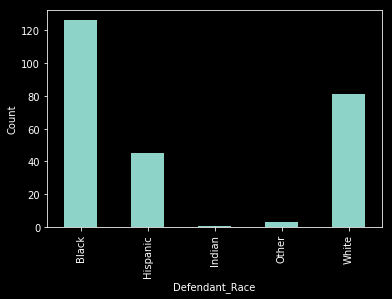

In [190]:
marijuana_race_counts.plot.bar()
plt.ylabel('Count')

Text(0, 0.5, 'Count')

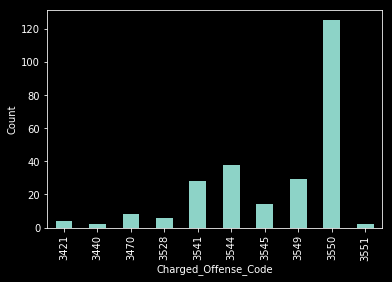

In [191]:
marijuana_offense_code_counts.plot.bar()
plt.ylabel('Count')

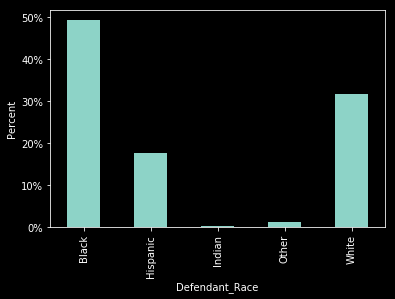

In [192]:
from matplotlib.ticker import FuncFormatter

marijuana_race_pct = marijuana_race_counts / marijuana_race_counts.sum()
ax = marijuana_race_pct.plot.bar()
plt.ylabel('Percent')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [193]:
marijuana['Probation_Frame'].replace({'Y': 365, 'M': 30, 'D': 1, '.': np.nan}, inplace=True)
marijuana['Probation_Length'].replace({'.': np.nan}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [194]:
marijuana['Probation_Length'] = marijuana['Probation_Length'].replace({'.': np.nan})
marijuana['Probation_Length'] = marijuana['Probation_Length'].astype(float)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [195]:
marijuana['Probation_Length'] = marijuana['Probation_Length'] * marijuana['Probation_Frame']
marijuana_probation_length = marijuana['Probation_Length'].dropna()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Probation Period (Days)')

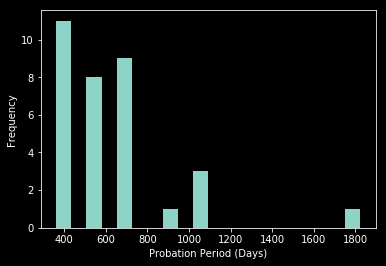

In [196]:
marijuana_probation_length.plot.hist(bins=20)
plt.xlabel('Probation Period (Days)')

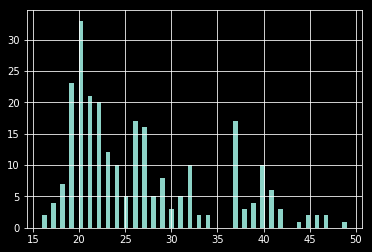

In [199]:
marijuana['Age'].hist(bins=int(max(df['Age'])-min(df['Age'])))